In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from scipy.ndimage import label, generate_binary_structure
from project.utils import reindex_cell_labels
from project.cell import Cell, CellContainer

#### We load the curated testing set 

The annotation from CellPos program were manually checked to remove or correct error and establish a ground truth on a testing set that was not used to train DELTA models

In [5]:
true_seg_test_file = "data/ground_truth/segmentation/testing_set_curated.tif"
_, true_seg_test = cv2.imreadmulti(true_seg_test_file, [], cv2.IMREAD_ANYDEPTH)

#### Recovering DELTA predictions made with default weights

In [13]:
test_pred_dir = "data/predictions/segmentation/delta_default_weights_test/"
list_files = sorted(os.listdir(test_pred_dir))
delta_d_test = np.zeros((125,512,512))

for f, file in enumerate(list_files):
    I = np.array(cv2.imread(test_pred_dir + file))
    I = I[:,:,0] # convert to gray scale 
    I[I>0] = 1 # Convert to binary mask
    delta_d_test[f,:,:] = label(I)[0]

#### Recover DELTA predictions made with custom weights 

In [6]:
# Predictions are written in the form of many png files that needs to be compiled in a tif
test_pred_dir = "data/predictions/segmentation/delta_custom_weights_test/"
list_files = sorted(os.listdir(test_pred_dir))
delta_custom_test = np.zeros((125,512,512))
for f, file in enumerate(list_files):
    I = np.array(cv2.imread(test_pred_dir + file))
    I_gray = I[:,:,0]
    I_gray[I_gray>0] = 1
    delta_custom_test[f,:,:] = label(I_gray)[0]

#### Recovering Illastik predictions 

In [7]:
illastik_seg_file = "data/predictions/segmentation/ilastik/seg_ilastik_test.tif"
_, illastik_seg = cv2.imreadmulti(illastik_seg_file, [], cv2.IMREAD_ANYDEPTH)
illastik_segs_test = np.zeros((125,512,512))
for f in range(125):
    illastik_segs_test[f,:,:] = label(illastik_seg[f])[0]

We check that we got the same image segmentation on a figure :

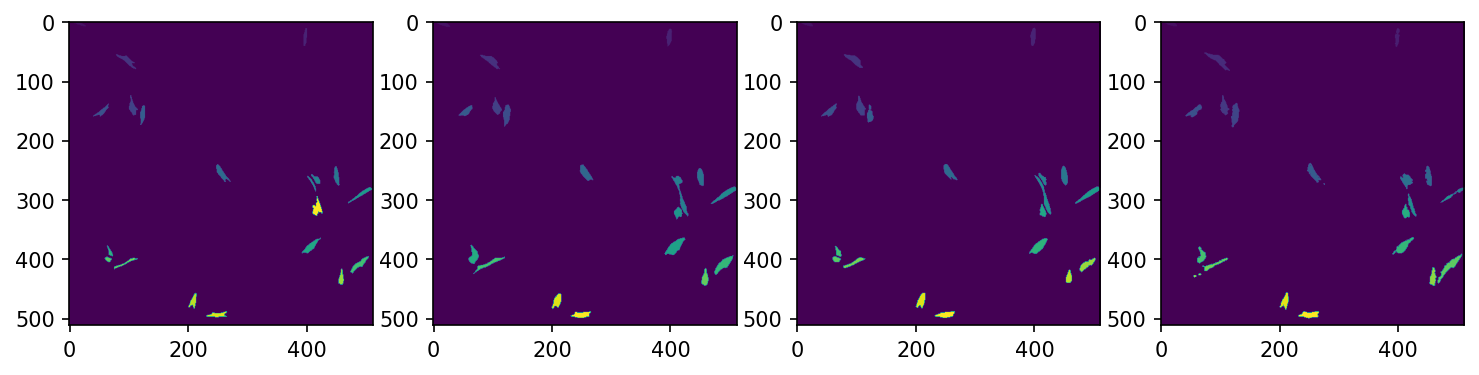

In [14]:
fig, axs = plt.subplots(1,4,figsize=(12,6), dpi=150)
axs[0].imshow(true_seg_test[0])
axs[1].imshow(delta_d_test[0])
axs[2].imshow(delta_custom_test[0])
axs[3].imshow(illastik_segs_test[0])

#### Score Cell Segmentation predictions

In the following line, we compare the overlap of each segmentation methods with the ground truth segmentation. As in DELTA original paper, we consider a segmentation as a success if there is enough overlap between the prediction and the ground truth, and a failure otherwise. In original DELTA, a threshold of 75% overlap was required. We lowered it to 51% as overlap seems to be generally lower in our biological context. The 51% threshold ensure that 2 cells cannot be counted as true. The overlap must satisfy A in B __and__ B in A. 

In [15]:
# Initialize list of results
scores_delta_te, accuracy_delta_te, scores_illastik_te, accuracy_illastik_te = [], [], [], []
scores_cu_te, accuracy_cu_te = [], []

# Iterate iver frames in movie to recover segmentation predictions
for f in range(125):
    print(f)
    
    ### Load data for testing set 
    true_segs_test = true_seg_test[f].copy()
    pseg_delta_d_te = delta_d_test[f].copy()
    pseg_illastik_te = illastik_segs_test[f].copy()
    pseg_delta_c_te = delta_custom_test[f].copy()
    cc_true_seg_te = CellContainer(true_segs_test)
    cc_pred_seg_i_te = CellContainer(pseg_illastik_te)
    cc_pred_seg_dd_te = CellContainer(pseg_delta_d_te)
    cc_pred_seg_dc_te = CellContainer(pseg_delta_c_te)
    
    # Test for DELTA default predictions / TESTING
    cc_true_seg_te.find_NN_other_frame(cc_pred_seg_dd_te, 'tp1')
    score_d, acc_d = cc_true_seg_te.score_surface(true_segs_test, pseg_delta_d_te)
    scores_delta_te.append(score_d)
    accuracy_delta_te.append(acc_d)
    
    # Test for DELTA with custom weights / TESTING 
    cc_true_seg_te = CellContainer(true_segs_test)
    cc_true_seg_te.find_NN_other_frame(cc_pred_seg_dc_te, 'tp1')
    score_cu, acc_cu = cc_true_seg_te.score_surface(true_segs_test, pseg_delta_c_te)
    scores_cu_te.append(score_cu)
    accuracy_cu_te.append(acc_cu)
    
    # Test for ILLASTIK predictions / TESTING
    cc_true_seg_te = CellContainer(true_segs_test)
    cc_true_seg_te.find_NN_other_frame(cc_pred_seg_i_te, 'tp1')
    score_i, acc_i = cc_true_seg_te.score_surface(true_segs_test, pseg_illastik_te)
    scores_illastik_te.append(score_i)
    accuracy_illastik_te.append(acc_i)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124


As we get an unique accuracy score per frame, we group them by group of multiple frames. Hereafter, per group of 10 successive frames.

In [16]:
range_acc_illastik, range_acc_delta, range_acc_delta_c = [], [], []
for i in range(12):
    range_acc_illastik.append(np.array(accuracy_illastik_te)[i*10:i*10+10])
    range_acc_delta.append(np.array(accuracy_delta_te)[i*10:i*10+10])
    range_acc_delta_c.append(np.array(accuracy_cu_te)[i*10:i*10+10])

In [17]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

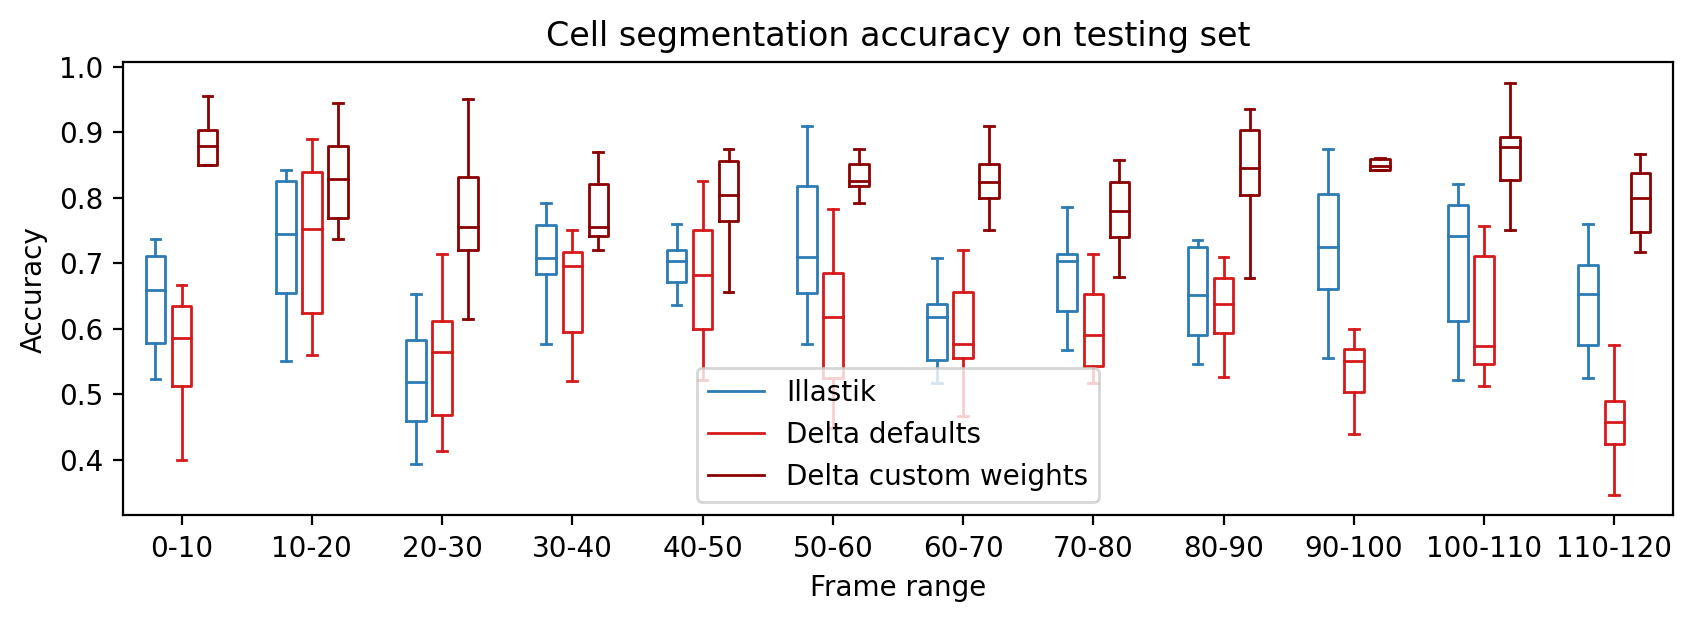

In [18]:
plt.figure(figsize=(10,3), dpi=200)
btr = plt.boxplot(range_acc_illastik, positions=np.array(range(len(range_acc_illastik)))*2.0-0.4, sym='', widths=0.3)
bte = plt.boxplot(range_acc_delta, positions=np.array(range(len(range_acc_delta)))*2.0, sym='', widths=0.3)
btc = plt.boxplot(range_acc_delta_c, positions=np.array(range(len(range_acc_delta)))*2.0+0.4, sym='', widths=0.3)
set_box_color(btr, '#2C7BB6') # colors are from http://colorbrewer2.org/
set_box_color(bte, '#D7191C')
set_box_color(btc, 'darkred')

plt.xticks([0,2,4,6,8,10,12,14,16,18,20,22],
           ['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100','100-110','110-120'])
plt.xlabel('Frame range')
plt.ylabel('Accuracy')
plt.title('Cell segmentation accuracy on testing set')
plt.legend([btr["boxes"][0], bte["boxes"][0], btc["boxes"][0]], ['Illastik', 'Delta defaults', 'Delta custom weights'], 
           loc='lower center')
#plt.savefig('results_explore_tif/cell_segmentation_testing_range10.pdf',dpi=300, bbox_inches='tight')
plt.show()